<a href="https://colab.research.google.com/github/anirbanghoshsbi/.github.io/blob/master/GET_FII_Data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [115]:
!pip install yfinance


In [116]:
import plotly.express as px
import plotly.graph_objects as go


In [117]:

import numpy as np
import pandas as pd
import yfinance as yf


In [118]:
nifty=yf.download('^NSEI',start='2018-08-16')
nif=nifty.reset_index()

[*********************100%***********************]  1 of 1 completed


In [119]:
import matplotlib.pyplot as plt

In [120]:
content='https://raw.githubusercontent.com/anirbanghoshsbi/data/main/'

In [121]:
data1=pd.read_csv(content+'fii1.txt',sep='\t',header=None)
data2=pd.read_csv(content+'fii2.txt',sep='\t',header=None)
data3=pd.read_csv(content+'fii3.txt',sep='\t',header=None)
data4=pd.read_csv(content+'fii4.txt',sep='\t',header=None)
data5=pd.read_csv(content+'fii5.txt',sep='\t',header=None)
data6=pd.read_csv(content+'fii6.txt',sep='\t',header=None)
data7=pd.read_csv(content+'fii7.txt',sep='\t',header=None)
data8=pd.read_csv(content+'fii8.txt',sep='\t',header=None)


In [122]:
data=[]

In [123]:
data=data1[0].tolist()
data.extend(data2[0].tolist())
data.extend(data3[0].tolist())
data.extend(data4[0].tolist())
data.extend(data5[0].tolist())
data.extend(data6[0].tolist())
data.extend(data7[0].tolist())
data.extend(data8[0].tolist())

In [124]:
len(data)

5061

In [125]:
lst=[]
lst.append(data[0:7])

In [126]:
for i in range(7,len(data)):
  if i%7==0:
    #print(i)
    lst.append(data[i:i+7])




In [127]:
df=pd.DataFrame()

In [128]:
for item in lst:
  to_append=item
  a_series = pd.Series(to_append)
  df = df.append(a_series, ignore_index=True)
print(df)

               0       1      2       3       4      5     6
0    22 Jul 2021    18.6  -53.9    1152   11013   -248   943
1    20 Jul 2021    18.7   50.8   -1785   11522  -2835   873
2    19 Jul 2021   -56.1   26.2   -2069   10705  -2199  1048
3    16 Jul 2021  -15.3   21.5   -1109   11865   -466   666 
4    15 Jul 2021    9.6    4.1     706   11750   -265   439 
..           ...     ...    ...     ...     ...    ...   ...
718  20 Aug 2018    1.9   -5.6    -118   31185   -483   593 
719  17 Aug 2018   15.6    4.0    -695   30356    147   152 
720  16 Aug 2018   -8.9   11.6    -433   28720   -825   134 
721  14 Aug 2018    3.4    7.7    -711   28727   -379   391 
722  13 Aug 2018   -2.9    1.0    -722   28024   -972   216 

[723 rows x 7 columns]


In [129]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 723 entries, 0 to 722
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   0       723 non-null    object
 1   1       723 non-null    object
 2   2       723 non-null    object
 3   3       723 non-null    object
 4   4       723 non-null    object
 5   5       723 non-null    object
 6   6       723 non-null    object
dtypes: object(7)
memory usage: 39.7+ KB


In [130]:
df.to_csv('fii.csv')

In [131]:
fii_fig= pd.read_csv('/content/fii.csv')

In [132]:
fii_fig=fii_fig[::-1]

In [133]:
fii_fig.tail(2)

,Unnamed: 0,0,1,2,3,4,5,6
1,1,20 Jul 2021,18.7,50.8,-1785,11522,-2835,873
0,0,22 Jul 2021,18.6,-53.9,1152,11013,-248,943


In [134]:
fii_fig.columns =['Index','Date','FIIcall','FIIput','FIIFuture','FIIFutOI','FIICash','DIIcash']

In [135]:
fii_fig.drop('Index',inplace=True,axis=1)

In [136]:
fii_fig=fii_fig.set_index('Date')

In [137]:
fii_fig.tail(3)

,FIIcall,FIIput,FIIFuture,FIIFutOI,FIICash,DIIcash
Date,,,,,,
19 Jul 2021,-56.1,26.2,-2069,10705,-2199,1048
20 Jul 2021,18.7,50.8,-1785,11522,-2835,873
22 Jul 2021,18.6,-53.9,1152,11013,-248,943


In [138]:
fii_fig['Cash']=fii_fig.FIICash+fii_fig.DIIcash

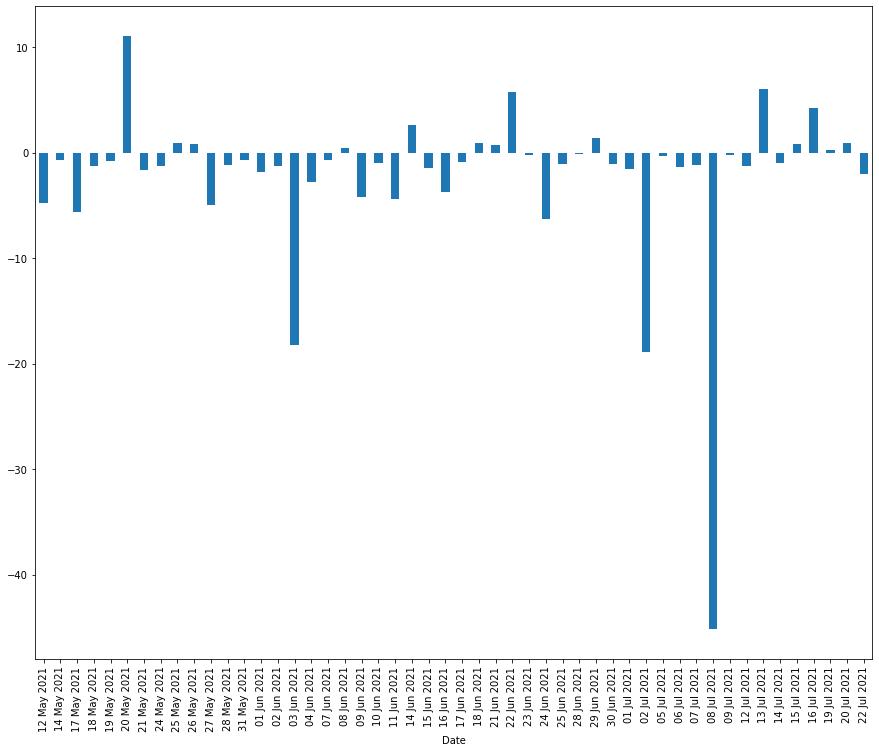

In [139]:
(fii_fig['FIIput'].pct_change()[-50:]).plot(kind='bar',figsize=(15,12))

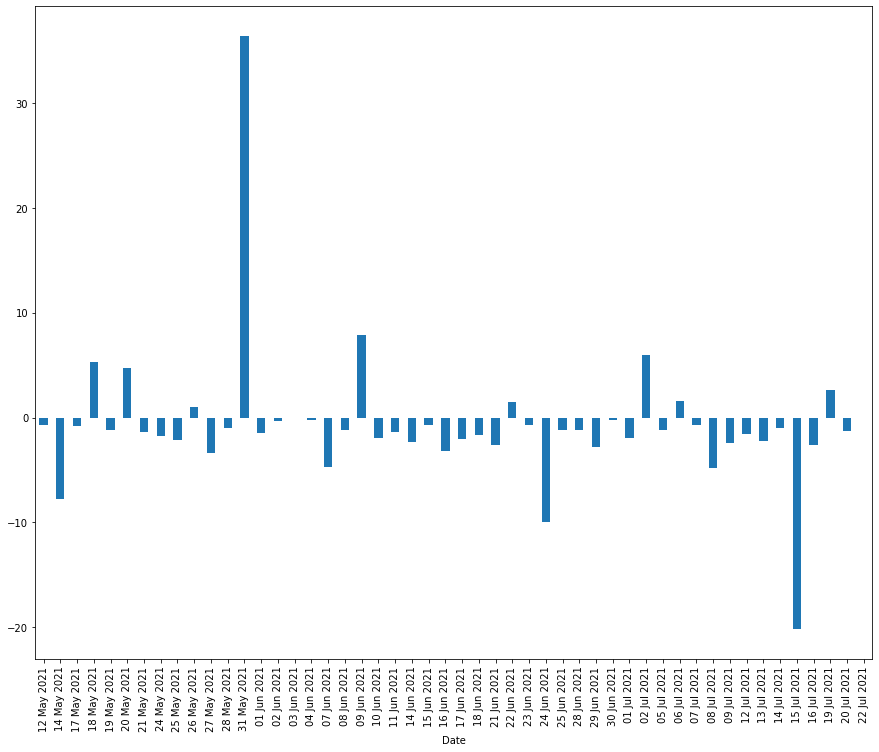

In [140]:
(fii_fig['FIIcall'].pct_change()[-50:]).plot(kind='bar',figsize=(15,12))

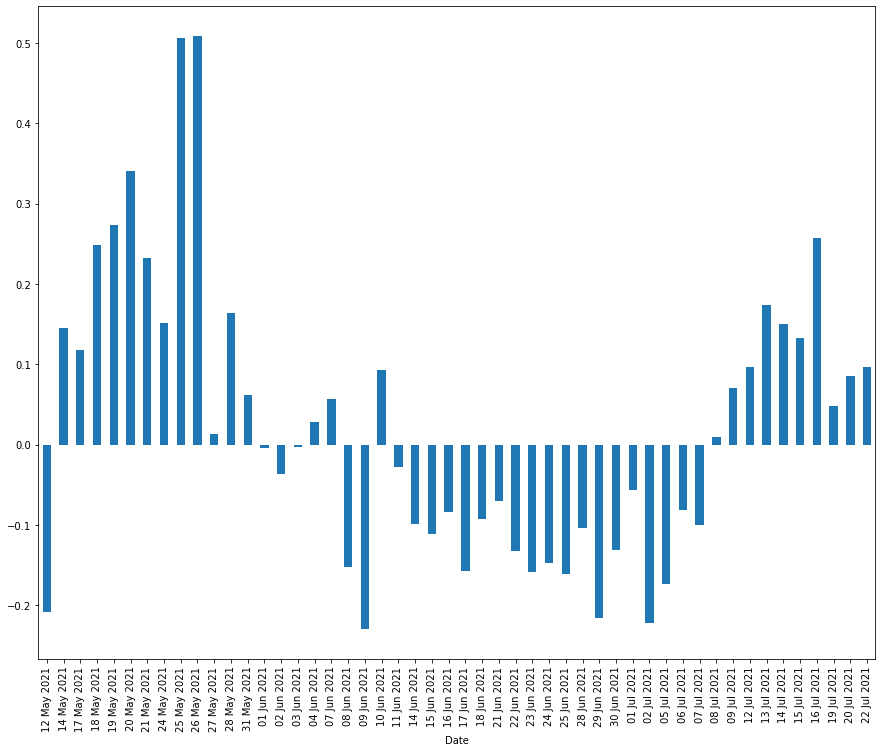

In [141]:
(fii_fig['FIIFutOI'].pct_change(10)[-50:]).plot(kind='bar',figsize=(15,12))


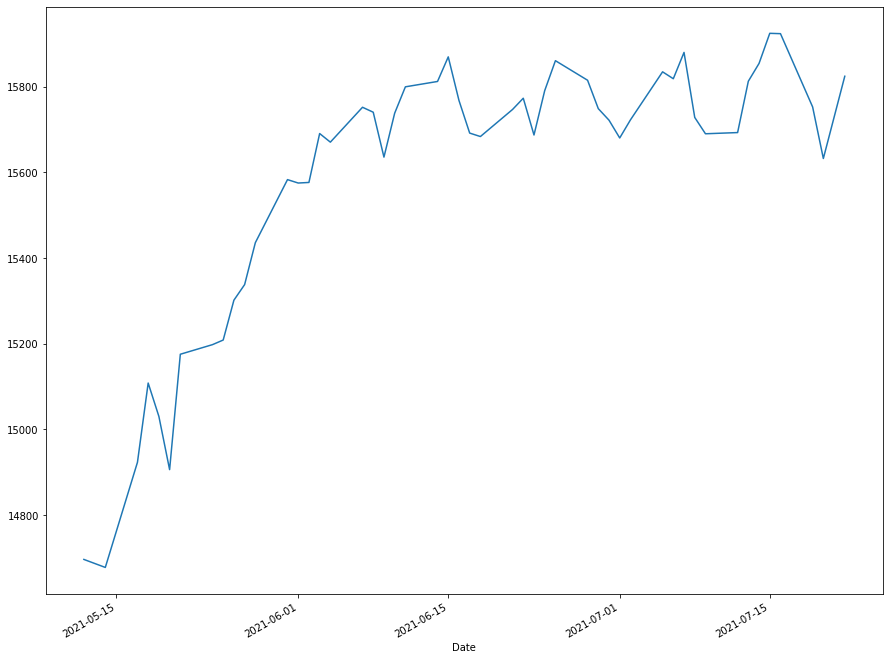

In [142]:
nifty['Close'][-50:].plot(figsize=(15,12))

In [143]:
fii_fig['MA200']=fii_fig.FIICash.rolling(window=200).mean()
fii_fig['MA50']=fii_fig.FIICash.rolling(window=50).mean()

In [144]:
fii_fig['macd']=fii_fig['FIICash'].ewm(span=50, adjust=False).mean()-fii_fig['FIICash'].ewm(span=200, adjust=False).mean()
fii_fig['signal']=fii_fig['macd'].ewm(span=35,adjust=False).mean()
fii_fig['hist']=fii_fig['macd']-fii_fig['signal'] 

In [145]:
fii_fig['macd_dom']=fii_fig['FIIFuture'].ewm(span=100, adjust=False).mean()-fii_fig['FIIFuture'].ewm(span=200, adjust=False).mean()
fii_fig['signal_dom']=fii_fig['FIIFuture'].ewm(span=50,adjust=False).mean()
fii_fig['hist_dom']=fii_fig['macd_dom']-fii_fig['signal_dom']

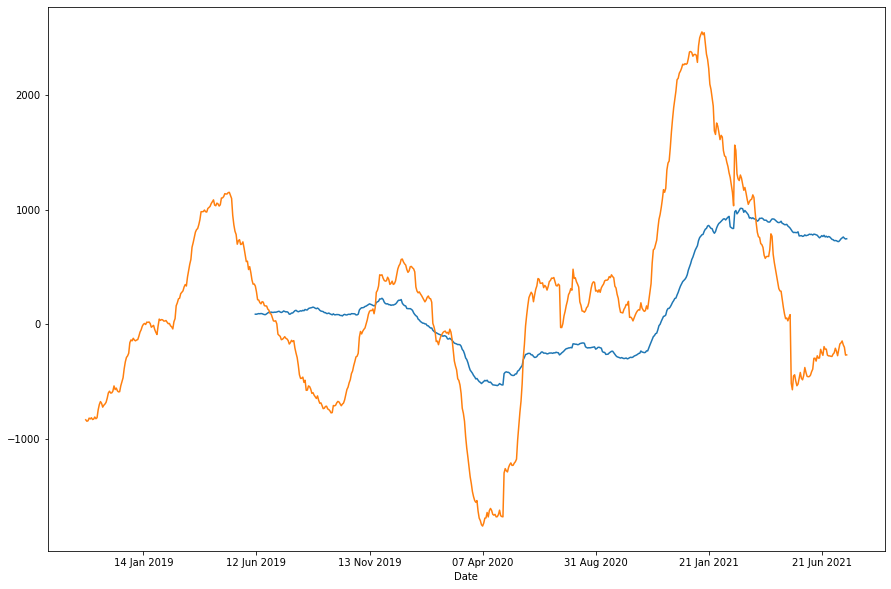

In [146]:
fii_fig.MA200.plot(figsize=(15,10))
fii_fig.MA50.plot()


# sample dataset from plotly express
df = fii_fig
# Filter and pivot dataset for each country,
# and add lines for each country
fig = go.Figure()
for c in ['MA200','MA50']:
    fig.add_traces(go.Scatter(x=df.index, y=df[c], mode='lines', name = c))

fig.show()

In [147]:


# sample dataset from plotly express
df = fii_fig
# Filter and pivot dataset for each country,
# and add lines for each country
fig = go.Figure()
for c in ['macd','signal']:
    fig.add_traces(go.Scatter(x=df.index, y=df[c], mode='lines', name = c))

fig.show()

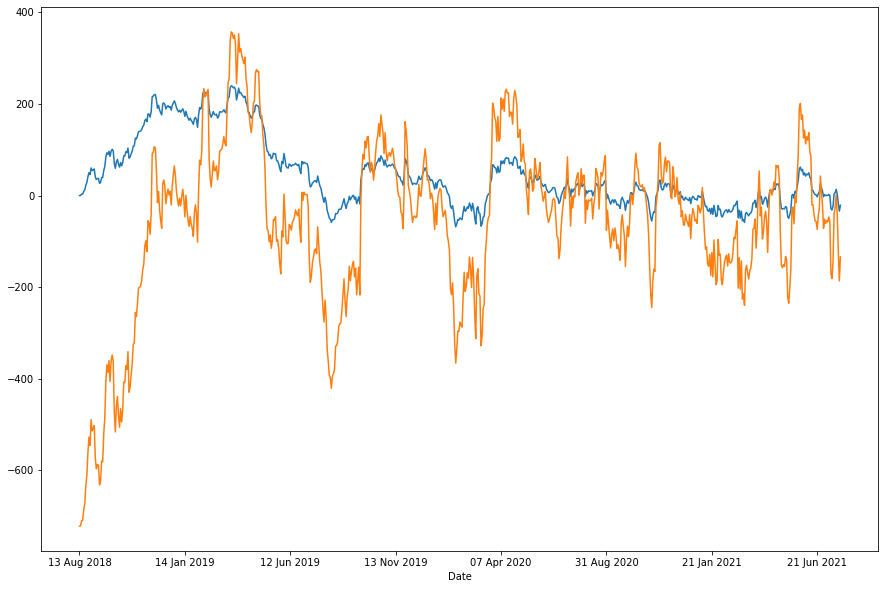

In [148]:
# sample dataset from plotly express
df = fii_fig
# Filter and pivot dataset for each country,
# and add lines for each country
fig1 = go.Figure()
for c in ['macd_dom','signal_dom']:
    fig1.add_traces(go.Scatter(x=df.index, y=df[c], mode='lines', name = c))

fig1.show()

fii_fig.macd_dom.plot(figsize=(15,10),xlabel='macd')
fii_fig.signal_dom.plot()
plt.show()


In [156]:
df=fii_fig.reset_index()
f=px.line(df,x='Date',y=df['signal_dom'].rolling(window=5).mean())
f.add_scatter(x=df['Date'],y=df['signal_dom'].rolling(window=100).mean(), mode='lines')
f.show()
fi=px.line(nif,x='Date',y='Close')
fi.show()

In [150]:
from plotly.subplots import make_subplots
df=fii_fig.reset_index()
fig = make_subplots(
    rows=2, cols=1,shared_xaxes=True,vertical_spacing=0.02,
    subplot_titles=("Smart Money","Nifty"))

fig.add_trace(go.Scatter(x=df.Date, y=df['macd'], mode='lines', name = 'macd'),
              row=1, col=1)

fig.add_trace(go.Scatter(x=df.Date, y=df['signal'], mode='lines', name = 'signal'),
              row=1, col=1)
fig.add_trace(go.Scatter(x=nif.Date, y=nif['Close'], mode='lines', name = 'Close'),
              row=2, col=1)

fig.update_layout(height=500, width=900,
                  title_text="Smart Money And Nifty")

fig.show()

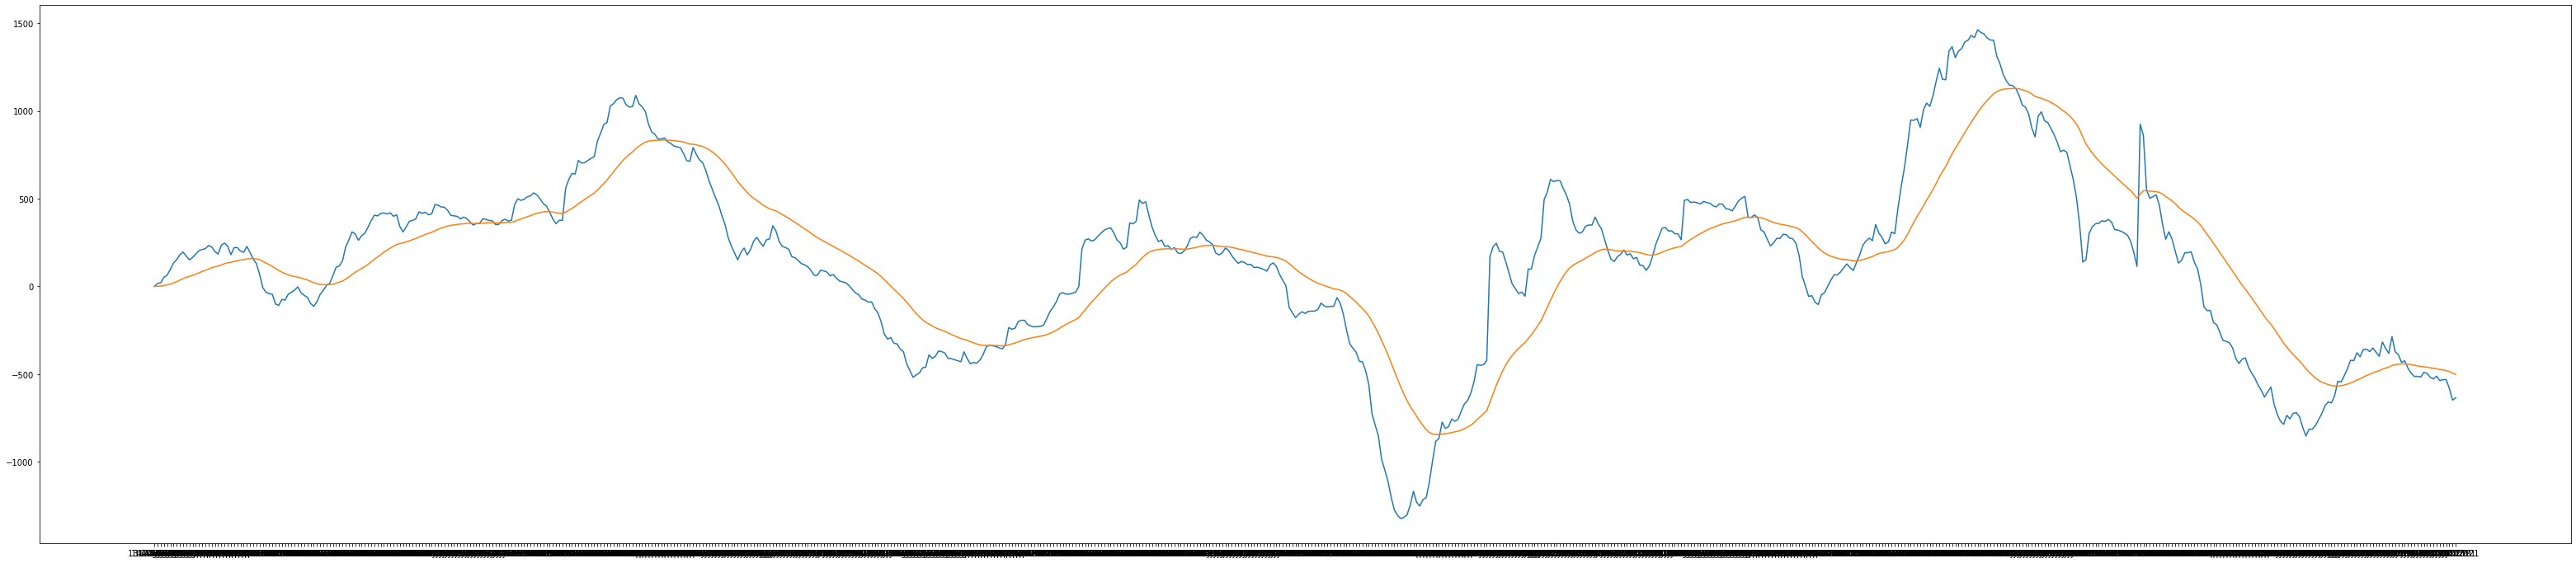

In [151]:
plt.figure(figsize=(55,12))
plt.plot(fii_fig.loc[:, :].index,fii_fig['macd'],label='MACD')
plt.plot(fii_fig.loc[:, :].index,fii_fig['signal'],label='Signal')
#plt.plot(fii_fig.loc[:, :].index)
plt.show()